# Homework 2: Stochastic Gradient Descent

## Exercise 1: SGD vs GD on a Simple 1D Regression Problem

Consider the synthetic dataset:

$$
x^{(i)} = \frac{i}{N},\qquad y^{(i)} = 2x^{(i)} + 1 + \varepsilon^{(i)}, \qquad \varepsilon^{(i)}\sim\mathcal N(0,0.01)
$$

with $N = 200$. We model the data with a linear function:

$$
f_\Theta(x) = \Theta_0 + \Theta_1 x = \Theta^T \tilde{x},
$$

if we define $\tilde{x} = [1, x]$ as we did during the lab session.

Implement the MSE loss:

$$
\mathcal L(\Theta)=\frac{1}{N}\sum_{i=1}^N (f_\Theta(x^{(i)}) - y^{(i)})^2.
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

seed = 211
rng = np.random.default_rng(seed)

In [7]:
N = 200
x_raw = np.linspace(0, 1, N)
noise = rng.normal(0, 0.1, N)
y = 2 * x_raw + 1 + noise

X = np.column_stack([np.ones(N), x_raw])

def mse_loss(theta, x, y):
    N = len(y)
    predictions = x @ theta
    return (1/N) * np.sum((predictions - y)**2)

def grad_f(theta, X_batch, y_batch):
    N_b = len(y_batch)
    predictions = X_batch @ theta
    # Gradient: (2/N) * X^T * (X*theta - y)
    return (2/N_b) * X_batch.T @ (predictions - y_batch)

In [10]:
def SGD(loss_f, grad_f, x, y, theta0, lr=1e-2, batch_size=32, epochs=10, full_gradient_history=False):
    """
    Simplified Stochastic Gradient Descent (SGD) implementation.
    loss_f: loss function, grad_f: gradient wrt Theta
    x, y: dataset
    theta0: initial parameters
    lr: learning rate
    """
    theta = theta0.copy()
    N = len(x)
    loss_history = [loss_f(theta, x, y)]
    path_history = [theta.copy()]
    if full_gradient_history:
        gradient_history = [np.linalg.norm(grad_f(theta, x, y))]
    else:
        gradient_history = None

    for _ in range(epochs):
        # Shuffle data indices
        idx = rng.permutation(N)
        for start in range(0, N, batch_size):
            batch_idx = idx[start:start+batch_size]
            grad = grad_f(theta, x[batch_idx], y[batch_idx])
            theta -= lr * grad

        loss_history.append(loss_f(theta, x, y))
        path_history.append(theta.copy())
        if full_gradient_history:
            gradient_history.append(np.linalg.norm(grad_f(theta, x, y)))

    return theta, loss_history, path_history, gradient_history

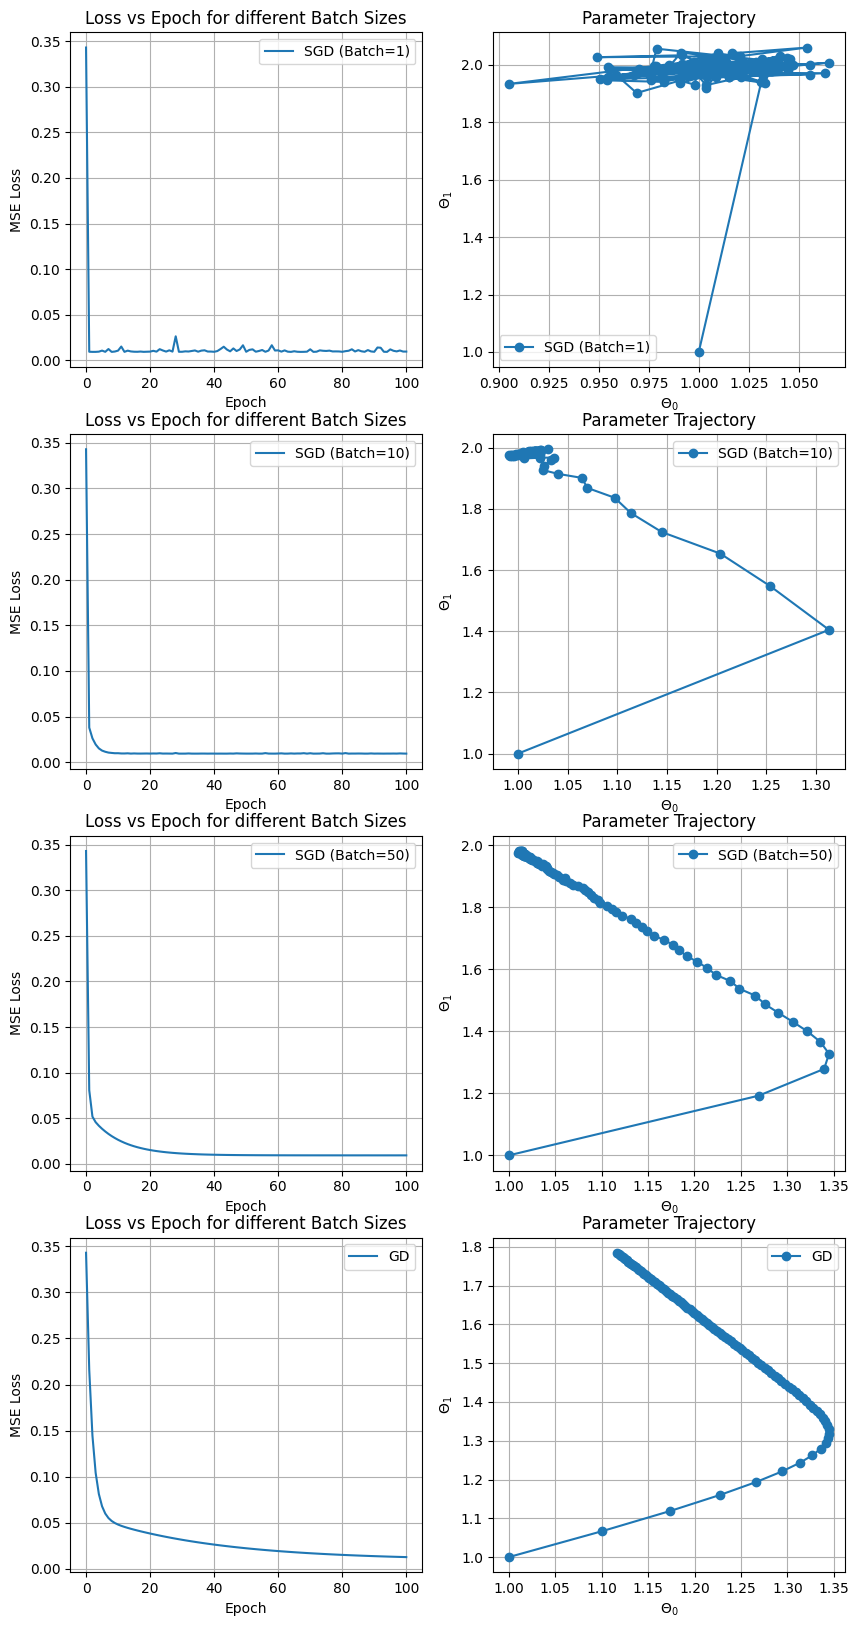

In [128]:
batch_sizes = [1, 10, 50, N]
results = {}

fig, ax = plt.subplots(len(batch_sizes), 2, figsize=(10, 5 * len(batch_sizes)))

for bs in batch_sizes:
    label = "GD" if bs == N else f"SGD (Batch={bs})"
    theta_final, losses, paths = SGD(mse_loss, grad_f, X, y, theta0=np.ones(X.shape[1]), batch_size=bs, lr=0.1, epochs=100)
    results[bs] = paths

    # Plot Loss Curve
    current_ax = ax[batch_sizes.index(bs), 0]
    current_ax.plot(losses, label=label)
    current_ax.set_xlabel("Epoch")
    current_ax.set_ylabel("MSE Loss")
    current_ax.set_title("Loss vs Epoch for different Batch Sizes")
    current_ax.legend()
    current_ax.grid(True)
    # current_ax.set_yscale('log')

    # Plot Parameter Trajectory
    paths_array = np.array(paths)
    current_ax = ax[batch_sizes.index(bs), 1]
    current_ax.plot(paths_array[:, 0], paths_array[:, 1], marker='o', label=label)
    current_ax.set_xlabel("$\\Theta_0$")
    current_ax.set_ylabel("$\\Theta_1$")
    current_ax.set_title("Parameter Trajectory")
    current_ax.legend()
    current_ax.grid(True)

plt.show()

## Exercise 2: Variance of the Stochastic Gradient

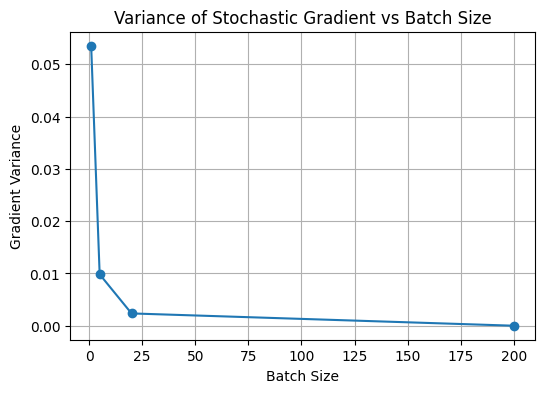

In [25]:
fixed_theta = np.array([1.0, 2.0])

batch_sizes_ex2 = [1, 5, 20, N]
variances = []

for bs in batch_sizes_ex2:
    gradients = []
    # Compute gradient 100 times for this batch size [Source 46]
    for _ in range(100):
        # Randomly sample a batch
        indices = rng.choice(N, bs, replace=False)
        x_sample = X[indices]
        y_sample = y[indices]

        g = grad_f(fixed_theta, x_sample, y_sample)
        gradients.append(g)

    # Var(g) = mean(||g_k - g_bar||^2)
    gradients = np.array(gradients)
    g_bar = np.mean(gradients, axis=0)
    variance = np.mean(np.sum((gradients - g_bar)**2, axis=1))
    variances.append(variance)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(batch_sizes_ex2, variances, 'o-')
plt.xlabel("Batch Size")
plt.ylabel("Gradient Variance")
plt.title("Variance of Stochastic Gradient vs Batch Size")
plt.grid(True)
plt.show()

## Exercise 3: SGD in 2D (Non-convex)

Loss function: $\mathcal{L}(\theta_1, \theta_2) = (\theta_1^2 - 1)^2 + 10 (\theta_2 - \theta_1^2)^2$

Gradient: $ \nabla \mathcal{L}(\theta_1, \theta_2) = \begin{bmatrix} 2(\theta_1^2 - 1)(2\theta_1) + 20(\theta_2 - \theta_1^2)(-2\theta_1) \\ 20(\theta_2 - \theta_1^2) \end{bmatrix} $

In [72]:
def nonconvex_loss(theta):
    t1, t2 = theta[0], theta[1]
    return (t1**2 - 1)**2 + 10 * (t2 - t1**2)**2

def nonconvex_grad(theta):
    t1, t2 = theta[0], theta[1]
    grad_t1 = 2 * (t1**2 - 1) * (2*t1) + 20 * (t2 - t1**2) * (-2*t1)
    grad_t2 = 20 * (t2 - t1**2)
    return np.array([grad_t1, grad_t2])

def run_noisy_sgd(theta_init, noise_level, lr=0.01, steps=200):
    if noise_level >=1:
        raise ValueError("Noise level should be less than 1.")
    theta = theta_init.copy()
    path = [theta.copy()]

    for _ in range(steps):
        true_grad = nonconvex_grad(theta)
        # noise: N(0, sigma^2 I)
        noise = rng.normal(0, np.sqrt(noise_level), size=2)
        noisy_grad = true_grad + noise

        theta -= lr * noisy_grad
        path.append(theta.copy())
    return np.array(path)

In [73]:
def levelset2d(func, xlim, ylim, levels=50, ax=None):
    x = np.linspace(xlim[0], xlim[1], 400)
    y = np.linspace(ylim[0], ylim[1], 400)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))

    if ax is None:
        ax = plt.gca()
    ax.contour(X, Y, Z, levels=levels, cmap='viridis')
    ax.set_xlabel('$\\theta_1$')
    ax.set_ylabel('$\\theta_2$')
    ax.grid(True)

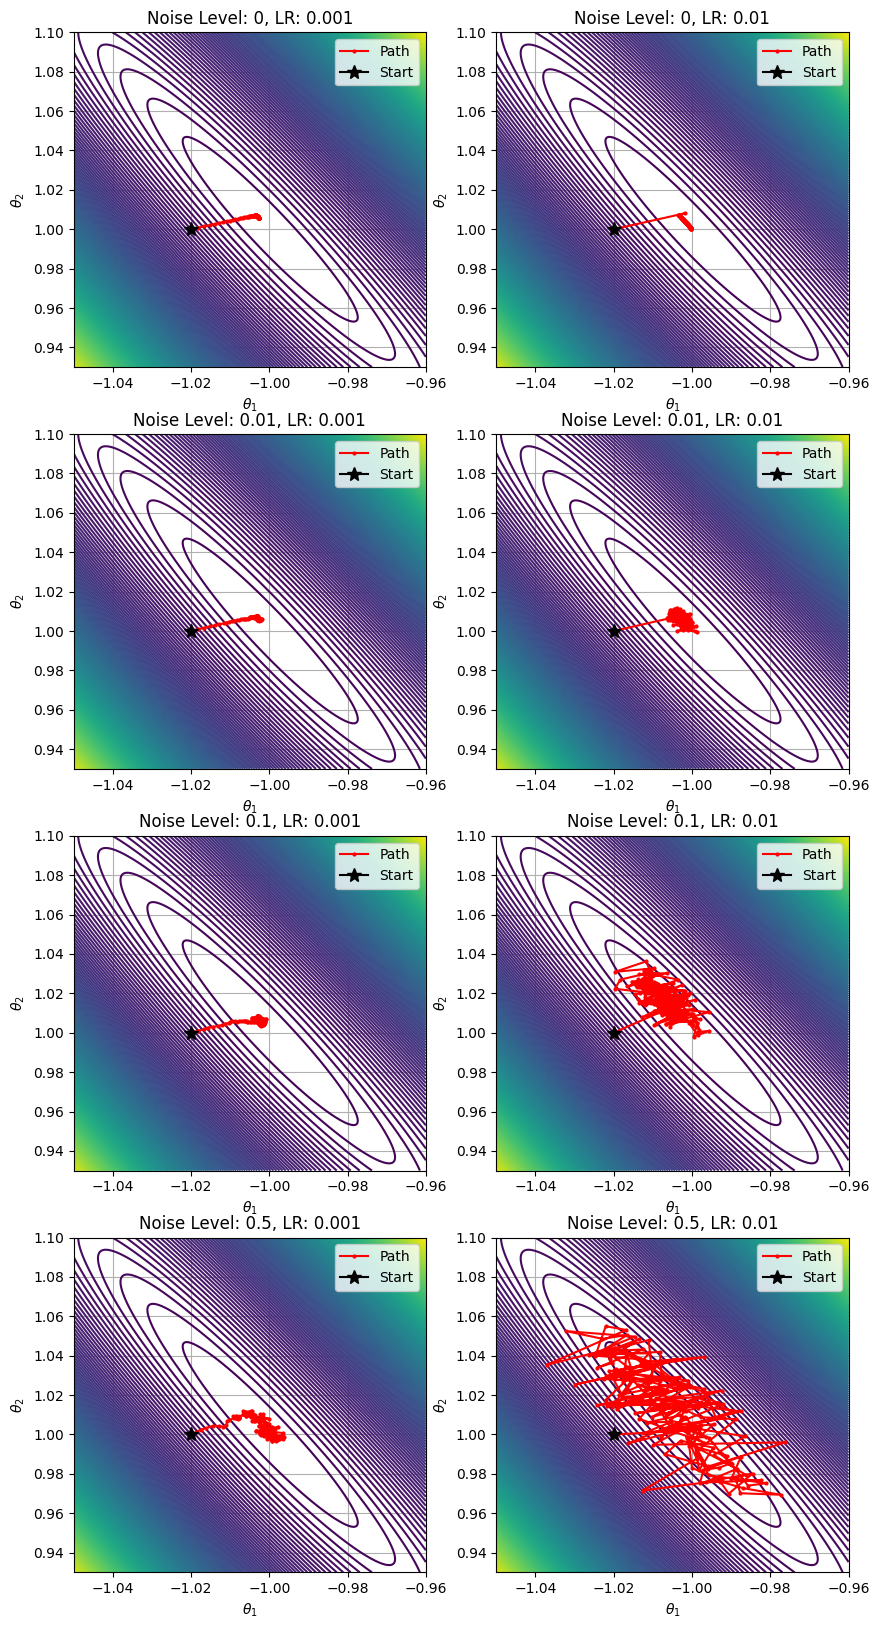

In [122]:
noise_levels = [0, 0.01, 0.1, 0.5]
lrs = [0.001, 0.01,]# 0.05, 0.1, 0.2]
initial_theta = np.array([-1.02, 1.0])

fig, axs = plt.subplots(len(noise_levels), len(lrs), figsize=(5*len(lrs), 5*len(noise_levels)))

for i, noise_level in enumerate(noise_levels):
    for j, lr in enumerate(lrs):
        ax = axs[i, j]
        levelset2d(nonconvex_loss, xlim=(-1.05, -0.96), ylim=(0.93, 1.1), levels=200, ax=ax)
        path = run_noisy_sgd(theta_init=initial_theta, noise_level=noise_level, lr=lr, steps=200)
        ax.plot(path[:, 0], path[:, 1], marker='o', color='red', markersize=2, label='Path')
        ax.plot(initial_theta[0], initial_theta[1], marker='*', color='black', markersize=10, label='Start')
        ax.set_title(f"Noise Level: {noise_level}, LR: {lr}")
        ax.legend()
plt.show()

## Exercise 4: An ML Project with SGD

In [23]:
# 1. Load dataset
df = pd.read_csv("insurance.csv")
# 2. Select features and target
features = ["age", "bmi", "children"]
target = "charges"

X_ins = df[features].values
y_ins = df[target].values

# 3. Standardize each feature (mean 0, variance 1)
X_mean = X_ins.mean(axis=0)
X_std = X_ins.std(axis=0)
X_scaled = (X_ins - X_mean) / X_std

# 4. Standardize target
y_mean = y_ins.mean()
y_std = y_ins.std()
y_scaled = (y_ins - y_mean) / y_std

# 5. Add bias
X_final = np.column_stack([X_scaled, np.ones(len(y_scaled))])

For linear model $f_\Theta(x) = \Theta^T \widetilde{x}$, let $\widetilde{x}$ be the input vector with bias term added as:

$$
\widetilde{x} = \begin{bmatrix} x_{age} \\ x_{bmi} \\ x_{children} \\ 1 \end{bmatrix}
$$

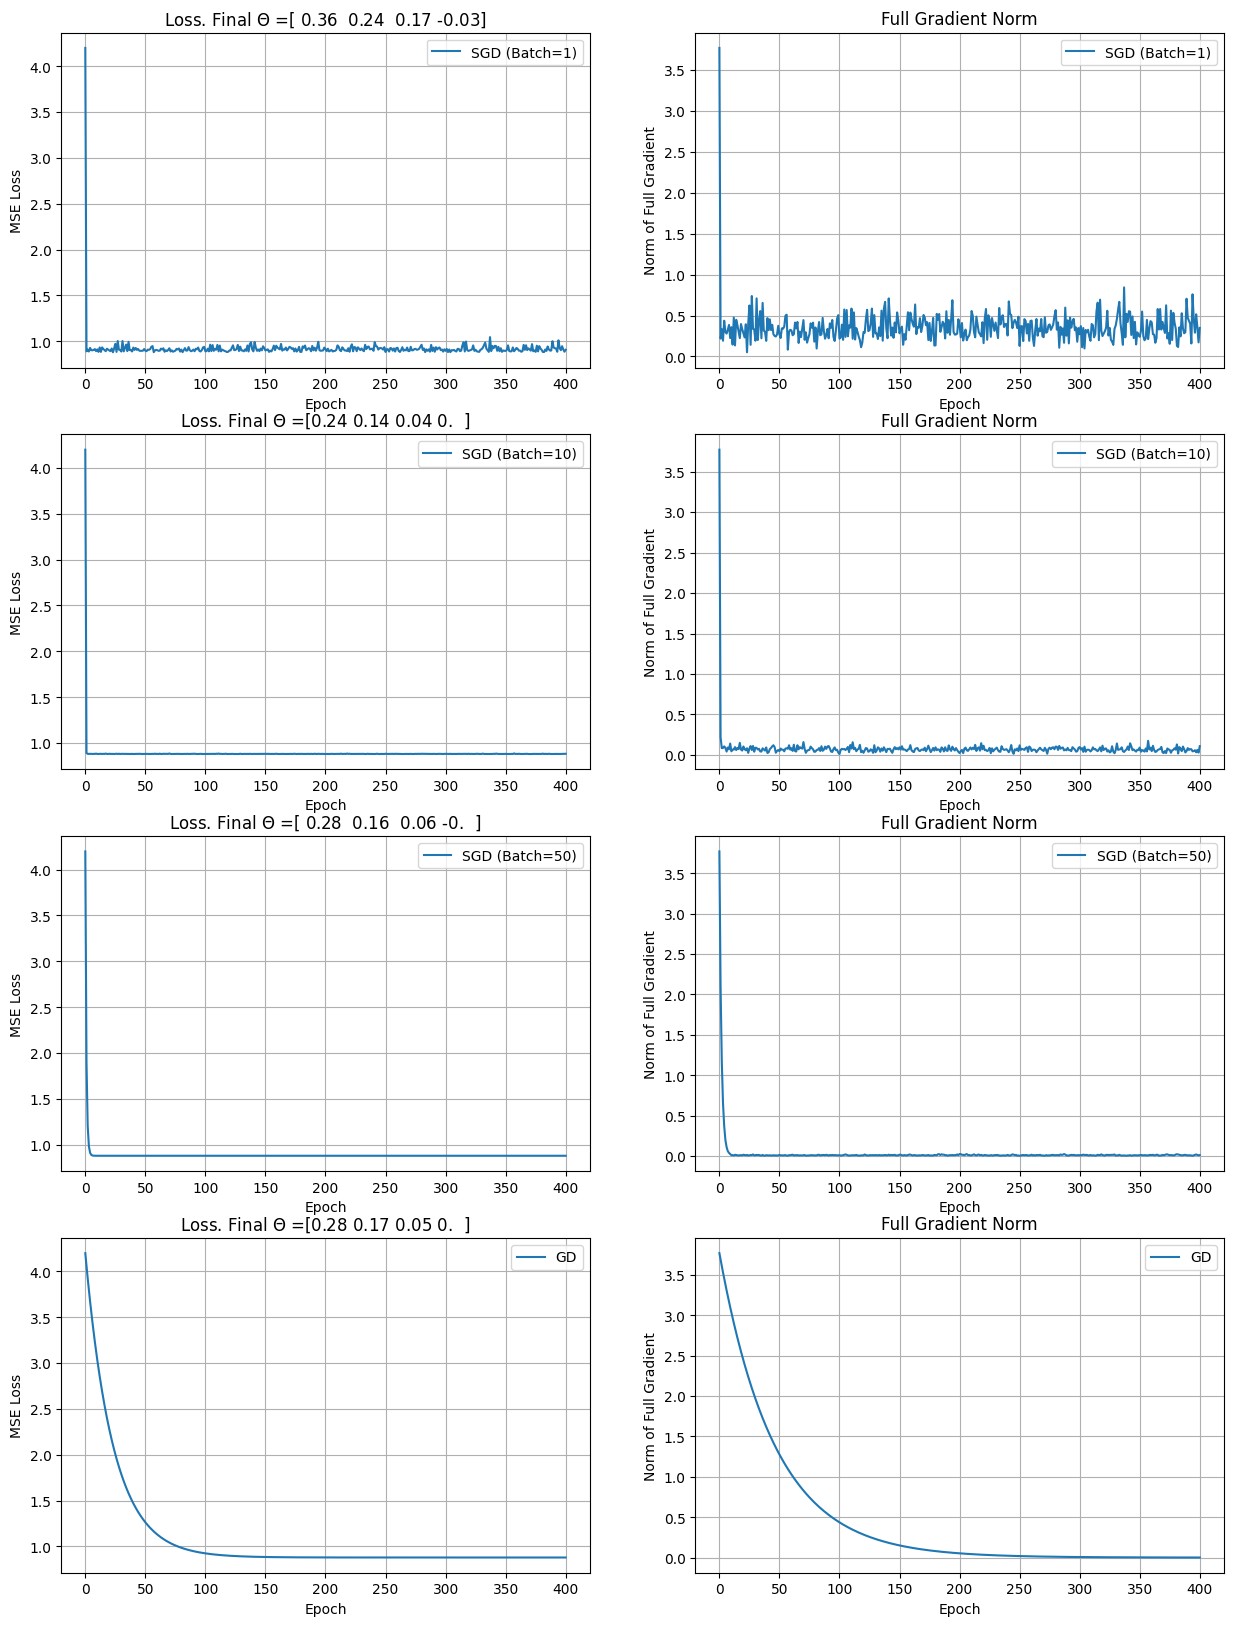

In [24]:
N = X_final.shape[0]
batch_sizes_ex4 = [1, 10, 50, N]

fig, ax = plt.subplots(len(batch_sizes_ex4), 2, figsize=(15, 5 * len(batch_sizes_ex4)))

for bs in batch_sizes_ex4:
    theta_final, losses, paths, gradients = SGD(mse_loss, grad_f, X_final, y_scaled, theta0=np.ones(X_final.shape[1]), batch_size=bs, lr=0.01, epochs=400, full_gradient_history=True)
    label = "GD" if bs == N else f"SGD (Batch={bs})"
    ax_current = ax[batch_sizes_ex4.index(bs), 0]
    ax_current.plot(losses, label=label)
    ax_current.set_xlabel("Epoch")
    ax_current.set_ylabel("MSE Loss")
    ax_current.legend()
    ax_current.grid(True)
    ax_current.set_title("Loss. Final $\\Theta$ =" + str(np.round(theta_final, 2)))

    ax_current = ax[batch_sizes_ex4.index(bs), 1]
    ax_current.plot(gradients, label=label)
    ax_current.set_xlabel("Epoch")
    ax_current.set_ylabel("Norm of Full Gradient")
    ax_current.legend()
    ax_current.grid(True)
    ax_current.set_title("Full Gradient Norm")

plt.show()